In [1]:
%reload_ext autoreload
%autoreload 2 
import pandas as pd
import numpy as np
import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, Hyperband, HyperParameters
from tensorflow.keras.callbacks import EarlyStopping

from DataEncoder import encode_pad_event, encode_pad_sequence, encode_y
from DurationEmbedding import duration_embedding_layer
from FeatureEmbedding import feature_embedding_layer
from DurationEmbeddingLSTM import DurationEmbeddingLSTMModel, print_best_hp_duration
from utils import plot_training_history_lstm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
event = pd.read_csv("D:/Research in UAE/sequence/output/BPI12f_Combin_Feature.csv")
sequence = event[['case:concept:name','case:AMOUNT_REQ','result']].groupby(['case:concept:name']).first()
sequence = sequence.reset_index()

In [3]:
event_duration_embedding = pd.read_csv("D:/Research in UAE/sequence/output/BPI_Event_Duration_Embedding_pro.csv")

In [4]:
y_col = sequence.result
y_encode = encode_y(y_col)

In [5]:
#cat_col_event = ['activity_verb', 'activity_dec', 'StartRes', 'CompleteRes']
cat_col_event = ['pre_activity', 'StartRes']
num_col_event = ['TimeDiff']
case_index = 'case:concept:name'

event_encode = encode_pad_event(event, cat_col_event, num_col_event, case_index, cat_mask = True, num_mask = True, eos = False)

In [6]:
cat_col_seq = []
num_col_seq = ['case:AMOUNT_REQ']
sequence_encode = encode_pad_sequence(sequence, cat_col_seq, num_col_seq)

In [7]:
event_duration_embedding_names = event_duration_embedding.columns.to_list()
embedding_duration_cols_names = event_duration_embedding_names[7:]
duration_embedding_encode = duration_embedding_layer(event_duration_embedding, embedding_duration_cols_names, case_index, eos = False)

In [8]:
# Define the input shape (sequence_length, number_of_features)
event_input_shape = (event_encode.shape[1], event_encode.shape[2])

# Define the number of classes 
num_classes = y_encode.shape[1]

# number of sequence features
num_sequence_features = sequence_encode.shape[1]

duration_embedding_shape = (duration_embedding_encode.shape[1], duration_embedding_encode.shape[2])


In [9]:
# Include batch size as a hyperparameter to be tuned
hp_b = HyperParameters()
batch_size = hp_b.Choice('batch_size', values=[16, 32, 64, 128])

In [10]:
# Split indices for train and test
train_indices, test_indices = train_test_split(np.arange(len(y_encode)), test_size=0.2, stratify=y_encode, random_state=42)

# Split the data
train_event_features = event_encode[train_indices]
test_event_features = event_encode[test_indices]

train_sequence_features = sequence_encode[train_indices]
test_sequence_features = sequence_encode[test_indices]

train_y = y_encode[train_indices]
test_y = y_encode[test_indices]

train_duration_embedding = duration_embedding_encode[train_indices]
test_duration_embedding = duration_embedding_encode[test_indices]


Duration Model

In [11]:
#Initialize the hypermodel
hypermodel = DurationEmbeddingLSTMModel(event_input_shape = event_input_shape,
                                        num_sequence_features = num_sequence_features,
                                        duration_embedding_shape = duration_embedding_shape,
                                        num_classes=num_classes)

early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=5, 
                               restore_best_weights=True)

tuner_band = Hyperband(hypermodel,
                       objective='val_accuracy',
                       max_epochs=200,
                       factor=3,
                       directory='hparam_tuning',
                       overwrite=False, #if resume tuner, keep overwrite = False
                       project_name='classfication_duration_embedding_BPI12',
                       hyperparameters=hp_b)

# Use the manually split data in the search
tuner_band.search(x=[train_event_features, train_duration_embedding, train_sequence_features], y=train_y, 
                  validation_data=([test_event_features, test_duration_embedding, test_sequence_features], test_y), 
                  epochs=200, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps_band = tuner_band.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model_band = tuner_band.get_best_models(num_models=1)[0]

Trial 254 Complete [01h 11m 53s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 2d 02h 29m 30s


C:\Users\ku\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 35 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [12]:
print_best_hp_duration(best_hps_band)

Best hyperparameters found were:
Number of Event LSTM layers: 1
  LSTM Layer 0:
    Units: 224
    Dropout Rate: 0.3647106089494904
    L2 Regularization: 0.001409614605832909
Number of Duration Embedding LSTM layers: 1
  LSTM Layer 0:
    Units: 32
    Dropout Rate: 0.3106228307556019
    L2 Regularization: 2.103054898777803e-05
    Batch Norm Momentum: 0.81
    Batch Norm Epsilon: 0.00024033422611295944
Number of Concatenate Event Feature LSTM layers: 1
  LSTM Layer 0:
    Units: 160
    Dropout Rate: 0.39109829307560895
    L2 Regularization: 1.5671297847121322e-05
    Batch Norm Momentum: 0.51
    Batch Norm Epsilon: 8.522069447043531e-05
Number of Dense layers: 1
  Dense Layer 0:
    Units: 224
    Activation: tanh
    Dropout Rate: 0.5758489747984508
    L2 Regularization: 0.00010977842096747566
Optimizer: adam
  Learning Rate (Adam): 0.0007037773259220206
  Beta 1 (Adam): 0.9099999999999999
  Beta 2 (Adam): 0.991
Learning Rate Schedule: polynomial
Best batch size: 128


In [ ]:
# Get predictions
y_pred_probs = best_model_band.predict([test_event_features, test_duration_embedding, test_sequence_features])
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(test_y, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute Classification Report
class_report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(class_report)

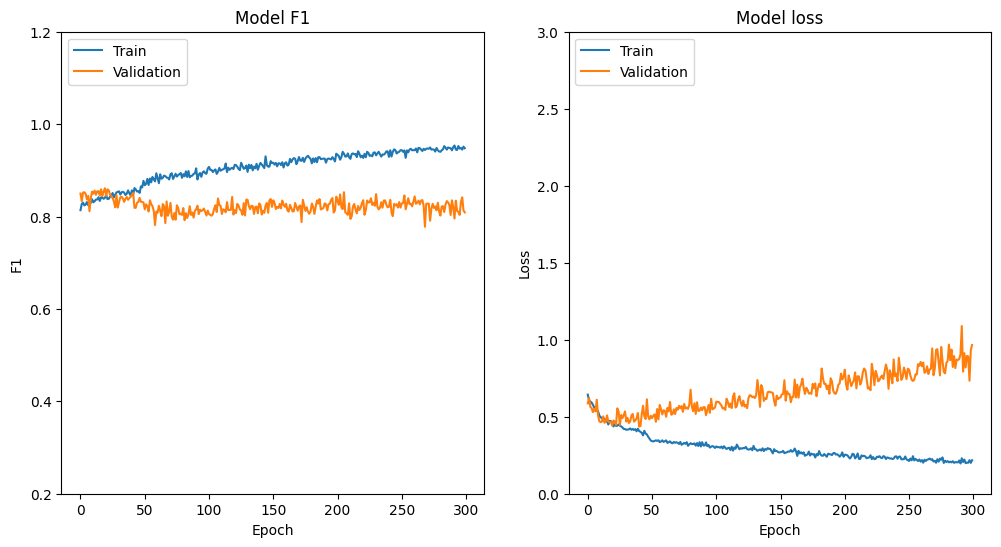

In [27]:
# alternatively, build the model with the optimal hyperparameters 
# best_model_band  = band_tuner.hypermodel.build(best_hps_band)
history_band = best_model_band.fit(x=[train_event_features, train_duration_embedding, train_sequence_features], y=train_y, 
                                   validation_data=([test_event_features, test_duration_embedding, test_sequence_features], test_y), 
                                   epochs=200, batch_size=best_hps_band.get('batch_size'), callbacks=[early_stopping])

val_acc_per_epoch_band = history_band.history['val_f1_score']
best_epoch_band = val_acc_per_epoch_band.index(max(val_acc_per_epoch_band)) + 1
print('Best epoch: %d' % (best_epoch_band,))
print('Best F1 Score: ', max(val_acc_per_epoch_band))
# Evaluate the best model
#loss, accuracy = best_model_band.evaluate([event_encode, sequence_encode],y_encode)
#print('Test accuracy:', accuracy)
print_best_hp_duration(best_hps_band)

plot_training_history_LSTMim(history_band.history)

Duration Feature model

In [12]:
#Initialize the hypermodel
hypermodel = FeatureDurationEmbeddingLSTMModel(event_input_shape = event_input_shape,
                                        num_sequence_features = num_sequence_features,
                                        feature_embedding_shape = feature_embedding_shape,
                                        duration_embedding_shape = duration_embedding_shape,
                                        num_classes=num_classes)

early_stopping = EarlyStopping(monitor='val_f1_score',  
                               mode='max',
                               patience=5, 
                               restore_best_weights=True)

tuner_band = Hyperband(hypermodel,
                       objective=kt.Objective("val_f1_score", direction="max"),
                       max_epochs=200,
                       factor=3,
                       directory='hparam_tuning',
                       overwrite=False, #if resume tuner, keep overwrite = False
                       project_name='classfication_feature_embedding_im',
                       hyperparameters=hp_b)

# Use the manually split data in the search
tuner_band.search(x=[train_event_features, train_feature_embedding, train_duration_embedding, train_sequence_features], y=train_y, 
                  validation_data=([test_event_features, test_feature_embedding, test_duration_embedding, test_sequence_features], test_y), 
                  epochs=200, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps_band = tuner_band.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model_band = tuner_band.get_best_models(num_models=1)[0]


Trial 247 Complete [00h 03m 38s]
val_f1_score: 0.8300619125366211

Best val_f1_score So Far: 0.8615099191665649
Total elapsed time: 06h 05m 20s


In [13]:
# Get predictions
y_pred_probs = best_model_band.predict([test_event_features, test_feature_embedding, test_duration_embedding, test_sequence_features])
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(test_y, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute Classification Report
class_report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(class_report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
Confusion Matrix:
[[ 92   0   0   0   0   0]
 [  0 170   0   0   4   0]
 [  0   0   5   0   0   0]
 [  0   0   2  19   0   0]
 [  0   0   0   0  32   0]
 [  0  40   0   0   9  55]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        92
           1     0.8095    0.9770    0.8854       174
           2     0.7143    1.0000    0.8333         5
           3     1.0000    0.9048    0.9500        21
           4     0.7111    1.0000    0.8312        32
           5     1.0000    0.5288    0.6918       104

    accuracy                         0.8715       428
   macro avg     0.8725    0.9018    0.8653       428
weighted avg     0.8976    0.8715    0.8615       428



Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - f1_score: 0.8314 - loss: 0.4203 - val_f1_score: 0.8511 - val_loss: 0.3854
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - f1_score: 0.8467 - loss: 0.3907 - val_f1_score: 0.8472 - val_loss: 0.3906
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - f1_score: 0.8277 - loss: 0.4132 - val_f1_score: 0.8520 - val_loss: 0.3901
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - f1_score: 0.8310 - loss: 0.4150 - val_f1_score: 0.8472 - val_loss: 0.3879
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - f1_score: 0.8275 - loss: 0.4095 - val_f1_score: 0.8575 - val_loss: 0.3836
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - f1_score: 0.8414 - loss: 0.4065 - val_f1_score: 0.8520 - val_loss: 0.3816
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - f1_score: 0.8337 - loss: 0.3977 - val_f1_score: 0.8593 - val_loss: 0.3774
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - f1_score: 0.8269 - loss: 0.4180 - val_f1_

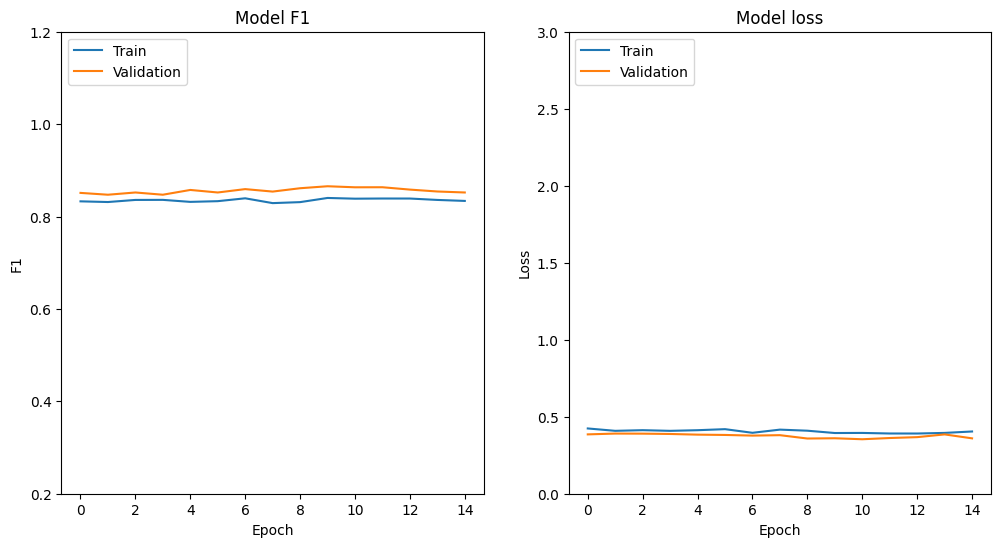

In [14]:
# alternatively, build the model with the optimal hyperparameters 
# best_model_band  = band_tuner.hypermodel.build(best_hps_band)
history_band = best_model_band.fit(x=[train_event_features, train_feature_embedding, train_duration_embedding, train_sequence_features], y=train_y, 
                                   validation_data=([test_event_features, test_feature_embedding, test_duration_embedding, test_sequence_features], test_y), 
                                   epochs=200, batch_size=best_hps_band.get('batch_size'), callbacks=[early_stopping])

val_acc_per_epoch_band = history_band.history['val_f1_score']
best_epoch_band = val_acc_per_epoch_band.index(max(val_acc_per_epoch_band)) + 1
print('Best epoch: %d' % (best_epoch_band,))
print('Best F1 Score: ', max(val_acc_per_epoch_band))

print_best_hp_duration_feature(best_hps_band)
plot_training_history_LSTMim(history_band.history)

In [ ]:
for key, value in best_hps_band.values.items():        
    print(f"{key}: {value}")

In [ ]:
# RandomSearch
tuner_rand= RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=300,
    executions_per_trial=2,
    directory='hparam_tuning',
    project_name='classfication_2levelfeatures_rand',
    hyperparameters=hp_b
)

tuner_rand.search(x=[event_encode, duration_embedding_encode, sequence_encode], y = y_encode,\
             epochs=300, validation_split=0.2, callbacks=[early_stopping])

# Get the best models and hyperparameters after search is randed
best_model_rand = tuner_rand.get_best_models(num_models=1)[0]
best_hps_rand = tuner_rand.get_best_hyperparameters(num_trials=1)[0]

# Fit the best model with the optimal batch size
best_model_rand.fit(
    [event_encode, sequence_encode],
    y_encode,
    epochs=300,
    batch_size=best_hps_rand.get('batch_size'),  # Use the best batch size found
    validation_split=0.2
)

# Evaluate the best model
loss, accuracy = best_model_rand.evaluate([event_encode, duration_embedding_encode, sequence_encode], y_encode)
print('Test accuracy:', accuracy)
print_best_hp(best_hps_rand)
#print_best_hp(best_hps)
best_model_rand.summary()